**PROJECT DESCRIPTION**

**1) IMPORTS**

In [1]:
import os
import numpy as np
import pandas as pd
import cv2  
from PIL import Image
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter

**2) DATASET DESCRIPTION**

*The dataset presented here is divided in two main groups with 3 subfolders with names COVID19, PNEUMONIA and NORMAL, each containing images related to Covid19 and Pneumonia infected people's ray-x chest images and normal ones. The first group is the train set, wich is composed by 74 samples of Pneumonia and Normal, while in the other hand there are 100 samples of people infected by Covid19. In the second group, wich is the test set, there are 50 cases of Covid19 samples and 20 Pneumonia and Normal people samples. (Add links of datasets)* 

In [2]:
#Global paths of the datasets
DATA_PATH = 'C:/Users/toshiba/datasets/xray_dataset_covid19_pneumonia_normal/'
train_COVID19_images_dir = DATA_PATH + 'train/COVID19/'
test_COVID19_images_dir = DATA_PATH + 'test/COVID19/'

train_COVID19_images = os.listdir(train_COVID19_images_dir)
test_COVID19_images = os.listdir(test_COVID19_images_dir)

In [3]:
#Printing number of samples of each type from the train set.
train_PNEUMONIA_images_dir = DATA_PATH + 'train/PNEUMONIA/'
train_NORMAL_images_dir = DATA_PATH + 'train/NORMAL/'

Normalimages = os.listdir(train_NORMAL_images_dir)
Pneumoniaimages = os.listdir(train_PNEUMONIA_images_dir)
COVID19images = os.listdir(train_COVID19_images_dir)

print('Total training images:', len(Normalimages) + len(Pneumoniaimages) + len(COVID19images))
print('Covid19 training images:', len(COVID19images))
print('Normal training images:', len(Normalimages))
print('Pneumonia training images:', len(Pneumoniaimages))

Total training images: 248
Covid19 training images: 100
Normal training images: 74
Pneumonia training images: 74


**3) VISUALIZING DATA SAMPLES**

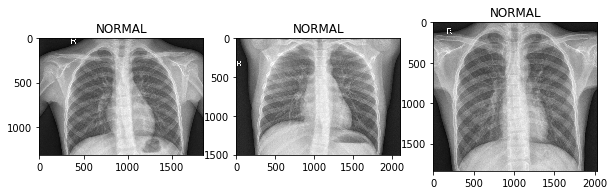

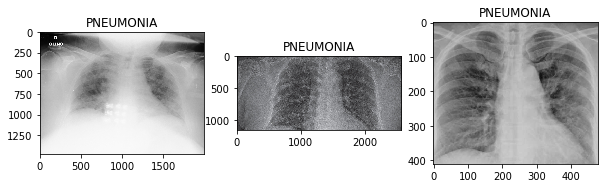

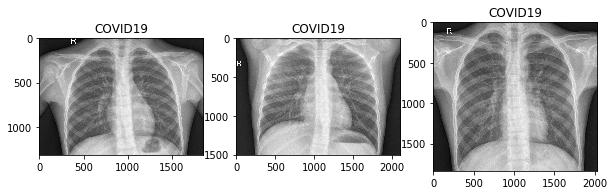

In [4]:
#Printing some samples of the training data types.
def print_sample_images(path, number_of_images, listdir, type_image):#This method prints 3 images of the type specified by listdir
    plt.figure(figsize=(10,10))
    for i in range(number_of_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(plt.imread(os.path.join(path, listdir[i])), cmap='gray')
        plt.title(type_image)
    plt.show()

listdir_array = [(Normalimages, train_NORMAL_images_dir, 'NORMAL'), (Pneumoniaimages, train_PNEUMONIA_images_dir, 'PNEUMONIA'), (Normalimages, train_NORMAL_images_dir, 'COVID19')]
for listdir in listdir_array:
    print_sample_images(listdir[1], 3, listdir[0], listdir[2])

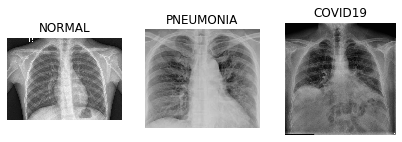

In [16]:
#Printing some samples of the training data types.
def print_sample_images(path, number_of_images, listdir, type_image, index):#This method prints 3 images of the type specified by listdir
    plt.figure(figsize=(7,7))
    for i in range(number_of_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(plt.imread(os.path.join(path[i], listdir[i][index[i]])), cmap='gray')
        plt.axis(False)
        plt.title(type_image[i])
    plt.show()

listdir_array = [([Normalimages, Pneumoniaimages, COVID19images], [train_NORMAL_images_dir, train_PNEUMONIA_images_dir, train_COVID19_images_dir], ['NORMAL', 'PNEUMONIA', 'COVID19'], [0,2,4] )] 
for listdir in listdir_array:
    print_sample_images(listdir[1], 3, listdir[0], listdir[2], listdir[3])

**4) DIVIDING DATA SAMPLES IN TRAINING SET AND TESTING SET. SETTING LABELS TO EACH SAMPLE**

In [5]:
#We create a DataFrame object for train set, and set the class label to each image.
image_names = pd.Series(list(COVID19images + Normalimages + Pneumoniaimages), list(range(len(COVID19images) + len(Normalimages) + len(Pneumoniaimages))))
image_classes = pd.Series(list(['COVID19' for i in range(100)] + ['NORMAL' for i in range(74)] + ['PNEUMONIA' for i in range(74)]), list(range(len(COVID19images) + len(Normalimages) + len(Pneumoniaimages))))
train_set = {'image_name' : image_names, 'class' : image_classes}
train_set = pd.DataFrame(train_set)

In [6]:
train_set

,image_name,class
0,006f3a8a.jpg,COVID19
1,00d96e05.jpg,COVID19
2,073a8f93.jpg,COVID19
3,08d780ae.jpg,COVID19
4,0a7faa2a.jpg,COVID19
...,...,...
243,nejmoa2001191_f3-PA.jpeg,PNEUMONIA
244,nejmoa2001191_f4.jpeg,PNEUMONIA
245,nejmoa2001191_f5-PA.jpeg,PNEUMONIA
246,pneumocystis-pneumonia-2-PA.png,PNEUMONIA


In [7]:
train_set.info()#getting info related to each atribute

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  248 non-null    object
 1   class       248 non-null    object
dtypes: object(2)
memory usage: 5.8+ KB


In [8]:
train_set.describe()#getting some description of main features of label images

,image_name,class
count,248,248
unique,248,3
top,IM-0110-0001.jpeg,COVID19
freq,1,100


In [9]:
#Creating a DataFrame object for test set, and set the class label to each image.
Normalimages = os.listdir(DATA_PATH + 'test/NORMAL/')
Pneumoniaimages = os.listdir(DATA_PATH + 'test/PNEUMONIA/')
COVID19images = os.listdir(DATA_PATH + 'test/COVID19/')
image_names = pd.Series(list(COVID19images + Normalimages + Pneumoniaimages), list(range(len(COVID19images) + len(Normalimages) + len(Pneumoniaimages))))
image_classes = pd.Series(list(['COVID19' for i in range(50)] + ['NORMAL' for i in range(20)] + ['PNEUMONIA' for i in range(20)]), list(range(len(COVID19images) + len(Normalimages) + len(Pneumoniaimages))))
test_set = {'image_name' : image_names, 'class' : image_classes}
test_set = pd.DataFrame(test_set)

In [10]:
test_set

,image_name,class
0,b0500187.jpg,COVID19
1,b39206a9.jpg,COVID19
2,b9673e89.jpg,COVID19
3,ba040c5e.jpg,COVID19
4,bace1e45.jpg,COVID19
...,...,...
85,streptococcus-pneumoniae-pneumonia-1.jpg,PNEUMONIA
86,streptococcus-pneumoniae-pneumonia-temporal-ev...,PNEUMONIA
87,streptococcus-pneumoniae-pneumonia-temporal-ev...,PNEUMONIA
88,streptococcus-pneumoniae-pneumonia-temporal-ev...,PNEUMONIA


In [11]:
test_set.info()#getting info related to each atribute

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  90 non-null     object
 1   class       90 non-null     object
dtypes: object(2)
memory usage: 2.1+ KB


In [12]:
test_set.describe()#getting info related to each atribute

,image_name,class
count,90,90
unique,90,3
top,c828e894.jpg,COVID19
freq,1,50


**5) PREPROCESSING IMAGES**

*Based on data inspection, images are scaled to a size of 244 by 244, normalized to values (0,1) and augmented by simple zoom and rotation to enhance the generalization.*    

In [13]:
#We define metadata used during the model training process.
image_size = 224 
BATCH_SIZE = 16 
NUM_TRAINING_IMAGES = len(train_set)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

#Preprocessing the training images.
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(DATA_PATH + '/train',
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

testing_set = test_datagen.flow_from_directory(DATA_PATH + '/test',
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

Found 248 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [14]:
print("train batch ", training_set.__getitem__(0)[0].shape)
print("test batch ", testing_set.__getitem__(0)[0].shape)
print("sample train label \n", training_set.__getitem__(0)[1][:5])

train batch  (16, 224, 224, 3)
test batch  (16, 224, 224, 3)
sample train label 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [15]:
training_set.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [16]:
testing_set.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

**6) AUXILIAR FUNCTIONS**

*Functions used for displaying relevant information about predictions and the main zones in every image for its classification.*
* **Class Activation Map (CAM)** visualization techniques produce heatmaps of 2D class activation over input images, showing how important each location is for the considered class. In the paper [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), the visualization is conducted by taking the output feature map of a convolution layer (given an input image), and then weighing every channel (feature map) by the gradient of the output class wrt the feature map.*

In [17]:
def display_training_curves(training, validation, title, subplot):#Method for displaying the training curves.
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [18]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [19]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

**7) LABEL SMOOTHING**

*[Label smoothing](https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/) is a mechanism for encouraging the model to be less confident. Instead of minimizing cross-entropy with hard targets (one-hot encoding), we minimize it using soft targets, this usually leads to a better generalization.*

In [20]:
# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

**8) CALLBACKS**

Callbacks: It is usually important to use callbacks while training. For example:
- ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving
- EarlyStopping: Stop training when a monitored metric has stopped improving

In [21]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

**9) TRANSFER LEARNING MODELS**

Instead of starting from scratch, **Transfer Learning** is used by loading a generic and well trained image classification network for feature extraction, and then adding few layers (head) to be trained for the target task. Three pretrained networks are used: 

- [DenseNet](https://arxiv.org/abs/1608.06993)
- [EfficientNetB7](https://arxiv.org/abs/1905.11946)
- [MobileNet](https://arxiv.org/abs/1905.11946)

Steps: 
- The pretrained network is loaded without the final classifcation head.
- Freeze the weights of the pretrained network.
- Add new head layers to be trained.

In [22]:
# dfault input shapes of the pretained models.
import efficientnet.tfkeras as efn
print(tf.keras.applications.DenseNet201(weights='imagenet').input_shape)
print(efn.EfficientNetB7(weights='imagenet').input_shape) 
print(tf.keras.applications.MobileNet(weights='imagenet').input_shape)

(None, 224, 224, 3)
(None, 600, 600, 3)
(None, 224, 224, 3)


**9.1) Pretained DenseNet201**

In [65]:
pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_densenet.layers:
  layer.trainable = False

x1 = pretrained_densenet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mse',metrics=['accuracy'])

model_densenet.summary()

Model: "model_123"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_66 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_66[0][0]']               
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                         

 conv4_block24_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 14, 14, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
          

                                                                                                  
 conv5_block23_0_bn (BatchNorma  (None, 7, 7, 1600)  6400        ['conv5_block22_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block23_0_relu (Activati  (None, 7, 7, 1600)  0           ['conv5_block23_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block23_1_conv (Conv2D)  (None, 7, 7, 128)    204800      ['conv5_block23_0_relu[0][0]']   
                                                                                                  
 conv5_block23_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block23_1_conv[0][0]']   
 lization)

In [66]:
history_densenet = model_densenet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=16)   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/16
16/16 [==============================] - 75s 4s/step - loss: 0.2198 - accuracy: 0.5040 - val_loss: 0.1252 - val_accuracy: 0.7222 - lr: 1.0000e-04
Epoch 2/16
16/16 [==============================] - 66s 4s/step - loss: 0.1244 - accuracy: 0.7500 - val_loss: 0.0834 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 3/16
16/16 [==============================] - 65s 4s/step - loss: 0.0896 - accuracy: 0.8065 - val_loss: 0.0614 - val_accuracy: 0.8667 - lr: 1.0000e-04
Epoch 4/16
16/16 [==============================] - 69s 4s/step - loss: 0.0811 - accuracy: 0.8387 - val_loss: 0.0558 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 5/16
16/16 [==============================] - 67s 4s/step - loss: 0.0731 - accuracy: 0.8589 - val_loss: 0.0541 - val_accuracy: 0.9111 - lr: 1.0000e-04
Epoch 6/16
16/16 [==============================] - 68s 4s/step - loss: 0.0579 - accuracy: 0.8790 - val_loss: 0.0408 - val_accuracy: 0.9222 - lr: 1.0000e-04
Epoch 7/16
16/16 [==============================] - 70s 4s

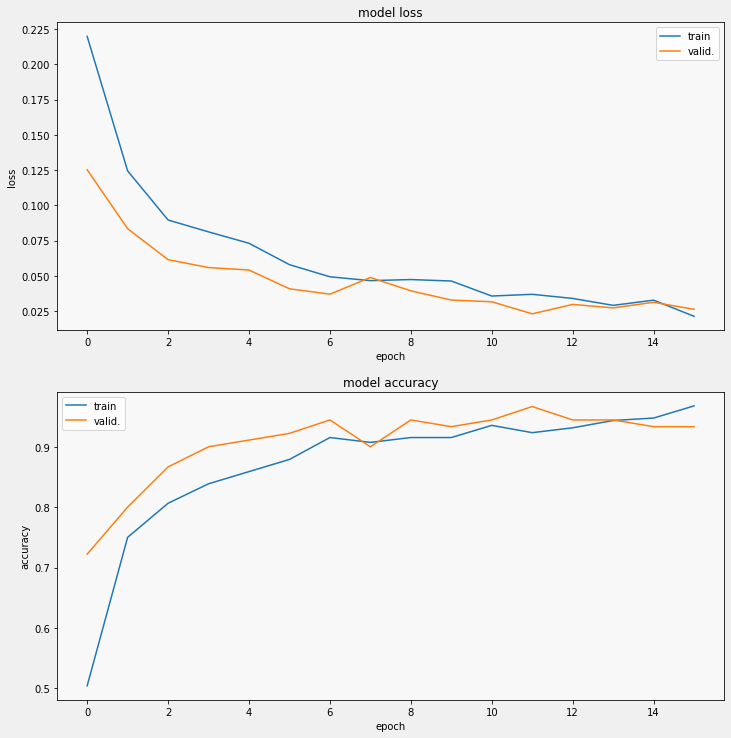

In [67]:
display_training_curves(history_densenet.history['loss'], history_densenet.history['val_loss'], 'loss', 211)
display_training_curves(history_densenet.history['accuracy'], history_densenet.history['val_accuracy'], 'accuracy', 212)

**9.1.1) Prediction Sample**

In [68]:
last_conv_layer_name = "conv5_block32_concat"
classifier_layer_names = [
    "bn",
    "relu",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

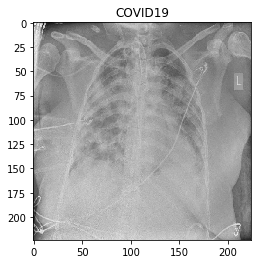

In [69]:
# test image
#bf551b8b.jpg
#d2af569b.jpg
#d680397c.jpg
#d7f2ee0f.jpg
#e1a4f870.jpg

file_path =  'C:/Users/toshiba/datasets/xray_dataset_covid19_pneumonia_normal/test/COVID19/bf551b8b.jpg'
test_image = cv2.imread(file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.title('COVID19')
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)

In [70]:
labels = ['COVID19', 'NORMAL', 'PNEUMONIA']
heatmap, top_index = make_gradcam_heatmap(test_image, model_densenet, last_conv_layer_name, classifier_layer_names)
print("predicted as", labels[top_index])

predicted as COVID19


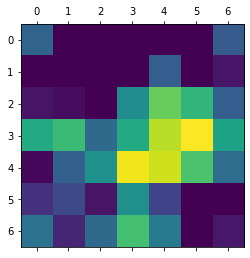

In [71]:
plt.matshow(heatmap)
plt.show()

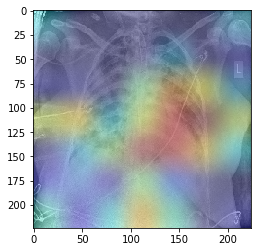

In [72]:
s_img = superimposed_img(test_image[0], heatmap)
plt.imshow(s_img)

In [73]:
model_densenet.save("model_densenet_30_09596.h5")

**9.2) Pretrained EfficientNetB7**

In [78]:
# https://github.com/keras-team/keras/issues/9064
pretrained_efnet = efn.EfficientNetB7(input_shape=(image_size, image_size, 3), weights='noisy-student', include_top=False)

for layer in pretrained_efnet.layers:
  layer.trainable = False

x2 = pretrained_efnet.output
x2 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x2)
x2 = tf.keras.layers.Flatten(name="flatten_head")(x2)
x2 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x2)
x2 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x2)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x2)

model_efnet = Model(inputs=pretrained_efnet.input, outputs=model_out)
model_efnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mse',metrics=['accuracy'])
model_efnet.summary()

Model: "model_127"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_69 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 64  1728        ['input_69[0][0]']               
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 64  256         ['stem_conv[0][0]']              
                                )                                                         

 block4i_se_excite (Multiply)   (None, 14, 14, 960)  0           ['block4i_activation[0][0]',     
                                                                  'block4i_se_expand[0][0]']      
                                                                                                  
 block4i_project_conv (Conv2D)  (None, 14, 14, 160)  153600      ['block4i_se_excite[0][0]']      
                                                                                                  
 block4i_project_bn (BatchNorma  (None, 14, 14, 160)  640        ['block4i_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4i_drop (FixedDropout)    (None, 14, 14, 160)  0           ['block4i_project_bn[0][0]']     
                                                                                                  
 block4i_a

 block6l_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6l_se_reduce[0][0]']      
                                                                                                  
 block6l_se_excite (Multiply)   (None, 7, 7, 2304)   0           ['block6l_activation[0][0]',     
                                                                  'block6l_se_expand[0][0]']      
                                                                                                  
 block6l_project_conv (Conv2D)  (None, 7, 7, 384)    884736      ['block6l_se_excite[0][0]']      
                                                                                                  
 block6l_project_bn (BatchNorma  (None, 7, 7, 384)   1536        ['block6l_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6l_d

In [79]:
history_efnet = model_efnet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=15)  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/15
16/16 [==============================] - 146s 8s/step - loss: 0.2342 - accuracy: 0.4556 - val_loss: 0.1744 - val_accuracy: 0.6556 - lr: 1.0000e-04
Epoch 2/15
16/16 [==============================] - 131s 8s/step - loss: 0.1987 - accuracy: 0.5645 - val_loss: 0.2220 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/15
16/16 [==============================] - 127s 8s/step - loss: 0.2181 - accuracy: 0.5403 - val_loss: 0.1241 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 4/15
16/16 [==============================] - 128s 8s/step - loss: 0.1818 - accuracy: 0.6290 - val_loss: 0.1199 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 5/15
16/16 [==============================] - 129s 8s/step - loss: 0.1910 - accuracy: 0.5887 - val_loss: 0.1366 - val_accuracy: 0.6889 - lr: 1.0000e-04
Epoch 6/15
16/16 [==============================] - 133s 9s/step - loss: 0.1411 - accuracy: 0.6815 - val_loss: 0.1670 - val_accuracy: 0.5889 - lr: 1.0000e-04
Epoch 7/15
16/16 [==============================] - 

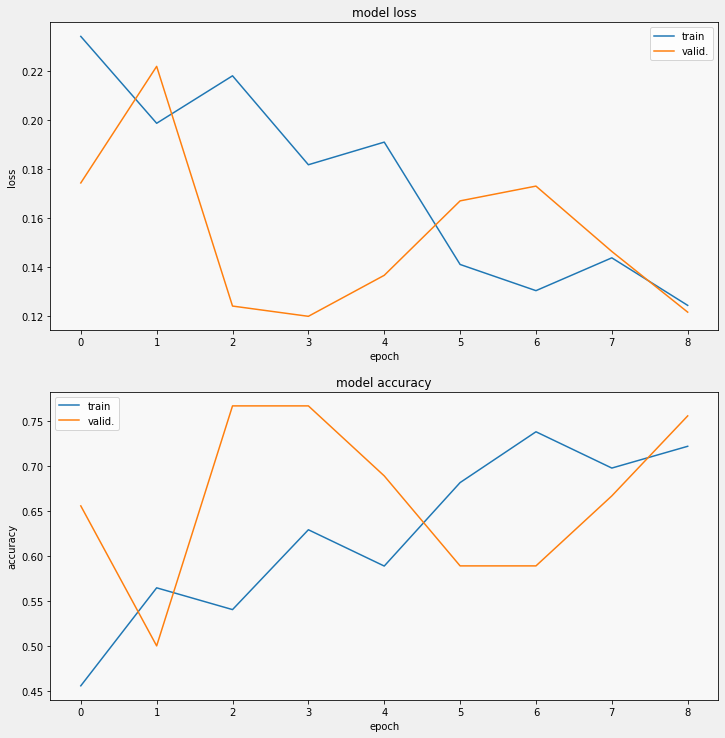

In [80]:
display_training_curves(history_efnet.history['loss'], history_efnet.history['val_loss'], 'loss', 211)
display_training_curves(history_efnet.history['accuracy'], history_efnet.history['val_accuracy'], 'accuracy', 212)

**9.2.1) Prediction Sample**

In [81]:
last_conv_layer_name = "top_conv"
classifier_layer_names = [
    "top_bn",
    "top_activation",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

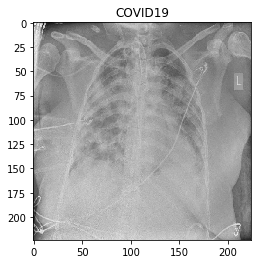

In [82]:
# test image
file_path =  'C:/Users/toshiba/datasets/xray_dataset_covid19_pneumonia_normal/test/COVID19/bf551b8b.jpg'
test_image = cv2.imread(file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.title('COVID19')
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)

In [83]:
model_efnet.save("model_efnet_30_09169.h5")

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


**9.3) Pretrained MobileNet**

In [84]:
pretrained_mobnet = tf.keras.applications.MobileNet(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_mobnet.layers:
  layer.trainable = False

x1 = pretrained_mobnet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x1)

model_mobnet = Model(inputs=pretrained_mobnet.input, outputs=model_out)
model_mobnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])

model_mobnet.summary()

Model: "model_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                  

In [85]:
history_mobnet = model_mobnet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=16)  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/16
16/16 [==============================] - 21s 1s/step - loss: 1.4448 - accuracy: 0.5323 - val_loss: 0.7651 - val_accuracy: 0.6778 - lr: 1.0000e-04
Epoch 2/16
16/16 [==============================] - 18s 1s/step - loss: 0.8796 - accuracy: 0.6613 - val_loss: 0.6009 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 3/16
16/16 [==============================] - 18s 1s/step - loss: 0.7345 - accuracy: 0.7621 - val_loss: 0.5491 - val_accuracy: 0.8667 - lr: 1.0000e-04
Epoch 4/16
16/16 [==============================] - 18s 1s/step - loss: 0.6855 - accuracy: 0.7460 - val_loss: 0.5207 - val_accuracy: 0.8667 - lr: 1.0000e-04
Epoch 5/16
16/16 [==============================] - 18s 1s/step - loss: 0.6001 - accuracy: 0.8468 - val_loss: 0.4986 - val_accuracy: 0.9222 - lr: 1.0000e-04
Epoch 6/16
16/16 [==============================] - 18s 1s/step - loss: 0.6012 - accuracy: 0.8468 - val_loss: 0.4776 - val_accuracy: 0.9222 - lr: 1.0000e-04
Epoch 7/16
16/16 [==============================] - 18s 1s

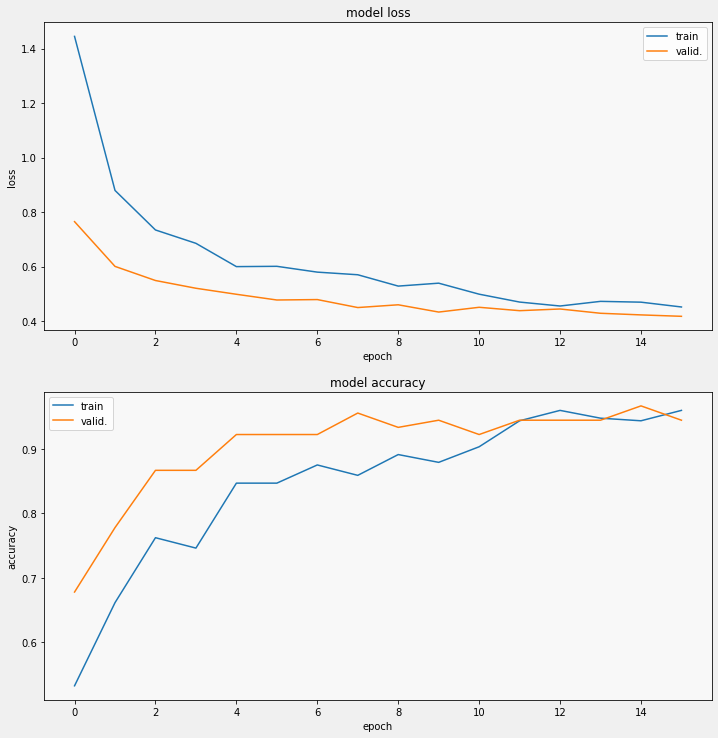

In [86]:
display_training_curves(history_mobnet.history['loss'], history_mobnet.history['val_loss'], 'loss', 211)
display_training_curves(history_mobnet.history['accuracy'], history_mobnet.history['val_accuracy'], 'accuracy', 212)

**9.3.1) Prediction Sample**

In [87]:
last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "dense_head_2",
    "dropout_head_2",
    "predictions_head"
]

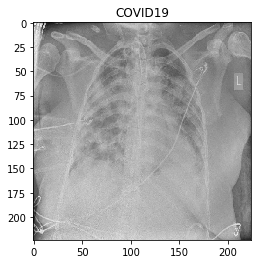

In [88]:
# test image
file_path =  'C:/Users/toshiba/datasets/xray_dataset_covid19_pneumonia_normal/test/COVID19/bf551b8b.jpg'
test_image = cv2.imread(file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.title('COVID19')
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)

In [89]:
model_mobnet.save("model_mobnet_30_09369.h5")

**10) Ensemble (simply at the last layer)**

In [93]:
# model_densenet
# model_efnet
# model_mobnet

for layer in model_densenet.layers:
  layer.trainable = False

for layer in model_efnet.layers:
  layer.trainable = False

for layer in model_mobnet.layers:
  layer.trainable = False

visible = tf.keras.layers.Input(shape=(image_size, image_size, 3), name="input")
x1 = model_densenet(visible)
x2 = model_efnet(visible)
x3 = model_mobnet(visible)
merge = tf.keras.layers.concatenate([x1, x2, x3], name="concatallprobs")
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions")(merge)

model_densenet_efnet_mobnet = Model(inputs=visible, outputs=model_out)
model_densenet_efnet_mobnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model_densenet_efnet_mobnet.summary()

Model: "model_130"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_123 (Functional)         (None, 3)            19428163    ['input[0][0]']                  
                                                                                                  
 model_127 (Functional)         (None, 3)            65572499    ['input[0][0]']                  
                                                                                                  
 model_128 (Functional)         (None, 3)            3818947     ['input[0][0]']          

In [94]:
history = model_densenet_efnet_mobnet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=16)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/16
16/16 [==============================] - 235s 13s/step - loss: 1.0842 - accuracy: 0.2984 - val_loss: 1.1260 - val_accuracy: 0.2222 - lr: 1.0000e-04
Epoch 2/16
16/16 [==============================] - 194s 12s/step - loss: 1.0646 - accuracy: 0.3065 - val_loss: 1.1215 - val_accuracy: 0.2222 - lr: 1.0000e-04
Epoch 3/16
16/16 [==============================] - 198s 13s/step - loss: 1.0638 - accuracy: 0.3024 - val_loss: 1.1169 - val_accuracy: 0.2222 - lr: 1.0000e-04
Epoch 4/16
16/16 [==============================] - 198s 13s/step - loss: 1.0692 - accuracy: 0.3065 - val_loss: 1.1122 - val_accuracy: 0.2222 - lr: 1.0000e-04
Epoch 5/16
16/16 [==============================] - 204s 13s/step - loss: 1.0431 - accuracy: 0.3105 - val_loss: 1.1075 - val_accuracy: 0.2222 - lr: 1.0000e-04
Epoch 6/16
16/16 [==============================] - 196s 12s/step - loss: 1.0289 - accuracy: 0.2984 - val_loss: 1.1028 - val_accuracy: 0.2222 - lr: 1.0000e-04
Epoch 7/16
16/16 [============================

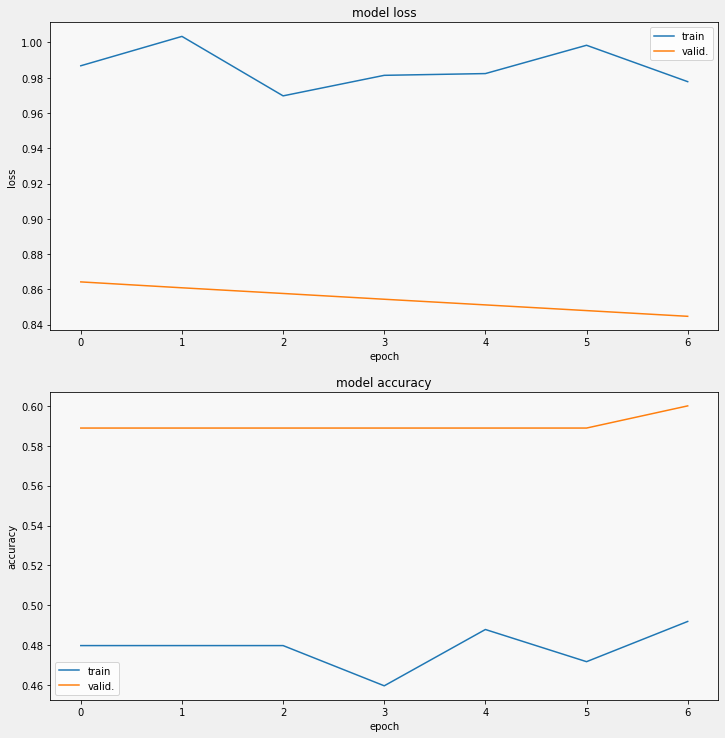

In [92]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [95]:
model_densenet_efnet_mobnet.save("model_densenet_efnet_mobnet_09581.h5")

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
